# iUROP YOLO Benchmarking
This notebook is part of the effort to benchmark different contemporary object detection algorithms with respect to traffic analysis.

Benchmarking points:

- Detection Time (Computational Cost)
- Vehicle Count
- Average Confidence
## Import Libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ultralytics import YOLO

## Custom Functions

In [2]:
# Function that creates a dataframe of 'URL','TIME_SG','DETECTION_TIME','CAR_COUNT', 'CAR_AVG_CONF','MOTOR_CYCLE_COUNT','MC_AVG_CONF','BUS_COUNT','BUS_AVG_CONF' 
# for results obtained from yolo
def benchmark_summary_YOLO(results, model, data_source, data_time):
        
    benchmark_results_YOLO = pd.DataFrame(columns=['URL',
                                                   'TIME_SG',
                                                   'DETECTION_TIME',
                                                   'CAR_COUNT', 
                                                   'CAR_AVG_CONF',
                                                   'MOTOR_CYCLE_COUNT',
                                                   'MC_AVG_CONF',
                                                   'BUS_COUNT',
                                                   'BUS_AVG_CONF',
                                                   'TRUCK_COUNT',
                                                   'TRUCK_AVG_CONF'
                                                   ])
    for i, result in enumerate(results):
        
        boxes = result.boxes
        cls_tensor = boxes.cls
        conf_tensor = boxes.conf

        # Reset counts and confidence counts
        car_count = 0
        car_conf_sum = 0
        motor_cycle_count = 0
        motor_cycle_conf_sum = 0
        bus_count = 0
        bus_conf_sum = 0
        truck_count = 0
        truck_conf_sum = 0
        # Count objects
        for j in range(len(cls_tensor)):
            
            class_index = int(cls_tensor[j].item())
            class_name = model.names[class_index]

            class_confidence = conf_tensor[j].cpu()

            if class_name == 'car':
                car_count += 1
                car_conf_sum += class_confidence
            elif class_name == 'truck':
                truck_count += 1
                truck_conf_sum += class_confidence
            elif class_name == 'bus':
                bus_count += 1
                bus_conf_sum += class_confidence
            else:
                motor_cycle_count += 1
                motor_cycle_conf_sum += class_confidence
            
            print(f"Object {j+1}: {class_name} (index {class_index})", f" with confidence:{class_confidence}")    

        
        # Evaluate average confidence for the different classes & bring them from GPU to CPU memory
    
        car_AVG_conf = car_conf_sum / car_count if car_count != 0 else 'N/A'
        car_AVG_conf = car_AVG_conf.cpu().numpy() if car_AVG_conf != 'N/A' else car_AVG_conf
        bus_AVG_conf = bus_conf_sum / bus_count if bus_count != 0 else 'N/A'
        bus_AVG_conf = bus_AVG_conf.cpu().numpy() if bus_AVG_conf != 'N/A' else bus_AVG_conf
        truck_AVG_conf = truck_conf_sum / truck_count if truck_count != 0 else 'N/A'
        truck_AVG_conf = truck_AVG_conf.cpu().numpy() if truck_AVG_conf != 'N/A' else truck_AVG_conf
        MC_AVG_conf = motor_cycle_conf_sum / motor_cycle_count if motor_cycle_count != 0 else 'N/A'
        MC_AVG_conf = MC_AVG_conf.cpu().numpy() if MC_AVG_conf != 'N/A' else MC_AVG_conf

        detection_time = result.speed  
        detection_time = detection_time['preprocess'] + detection_time['inference'] + detection_time['postprocess']
        
        row = pd.DataFrame({'URL': [data_source[i]],
                            'TIME_SG':[data_time[i]],
                            'DETECTION_TIME': [detection_time],
                            'CAR_COUNT': [car_count], 
                            'CAR_AVG_CONF': [car_AVG_conf],
                            'MOTOR_CYCLE_COUNT': [motor_cycle_count],
                            'MC_AVG_CONF': [MC_AVG_conf],
                            'BUS_COUNT': [bus_count],
                            'BUS_AVG_CONF': [bus_AVG_conf],
                            'TRUCK_COUNT': [truck_count],
                            'TRUCK_AVG_CONF': [truck_AVG_conf]})
        

        #result.show()
        benchmark_results_YOLO = pd.concat([benchmark_results_YOLO, row], ignore_index=True)

    return benchmark_results_YOLO


def remove_na_from_lists(*lists):
    cleaned_lists = []
    for lst in lists:
        cleaned_list = [conf for conf in lst if conf != 'N/A']
        cleaned_lists.append(cleaned_list)
    return cleaned_lists


## Accessing Example
For first prototyping the camera 2703 is choosen 

In [3]:
bm_data = pd.read_excel('example_data.xlsx',sheet_name='in')
bm_data.head()

,Unnamed: 0,Image_id,Cam_ID,Detection_Class,Detection_Score,Timestamp_sg_time,URL,ymin,xmin,ymax,xmax,Bounding_box_area,Proportion_bounding_box_0_100,Segmentation_pixels
0,0,0,2703,3,0.578911,2022-04-11 04:50:00,https://images.data.gov.sg/api/traffic-images/...,245.54533,577.65643,273.81723,613.67883,1018.4216,0.049114,0.002501
1,1,0,2703,8,0.236422,2022-04-11 04:50:00,https://images.data.gov.sg/api/traffic-images/...,245.73334,577.16020,275.06482,614.46740,1094.2751,0.052772,0.003661
2,2,0,2703,5,0.150083,2022-04-11 04:50:00,https://images.data.gov.sg/api/traffic-images/...,479.06200,1316.72000,510.78333,1392.13530,2392.2717,0.115368,0.006059
3,3,0,2703,7,0.108866,2022-04-11 04:50:00,https://images.data.gov.sg/api/traffic-images/...,165.20915,0.00000,1026.82870,817.30990,704210.2000,33.960754,0.011771
4,4,0,2703,8,0.051746,2022-04-11 04:50:00,https://images.data.gov.sg/api/traffic-images/...,247.07472,579.08545,268.10458,603.35190,510.3207,0.024610,0.021770


In [4]:
bm_data = bm_data[['Timestamp_sg_time','URL']]
bm_data.head()

,Timestamp_sg_time,URL
0,2022-04-11 04:50:00,https://images.data.gov.sg/api/traffic-images/...
1,2022-04-11 04:50:00,https://images.data.gov.sg/api/traffic-images/...
2,2022-04-11 04:50:00,https://images.data.gov.sg/api/traffic-images/...
3,2022-04-11 04:50:00,https://images.data.gov.sg/api/traffic-images/...
4,2022-04-11 04:50:00,https://images.data.gov.sg/api/traffic-images/...


Removing the duplicated rows:

In [5]:
bm_data.drop_duplicates(inplace=True)
bm_data.head()

,Timestamp_sg_time,URL
0,2022-04-11 04:50:00,https://images.data.gov.sg/api/traffic-images/...
6,2022-04-11 04:55:00,https://images.data.gov.sg/api/traffic-images/...
14,2022-04-11 05:00:00,https://images.data.gov.sg/api/traffic-images/...
24,2022-04-11 05:05:00,https://images.data.gov.sg/api/traffic-images/...
39,2022-04-11 05:10:00,https://images.data.gov.sg/api/traffic-images/...


In [6]:
print(bm_data.shape[0], "images are available!")

228 images are available!


## Import YOLO Model(s)

In [7]:
# Load COCO-pretrained YOLO11x model
YOLO_11x = YOLO("yolo11x.pt")
# Load COCO-pretrained YOLO11n model
YOLO_11n = YOLO("yolo11n.pt")


{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

## Inference & Benchmarking

In [8]:
# Select a sample of images:
n_randoms_images = 20
rand_images = bm_data.sample(n=n_randoms_images, random_state=22)
rand_images_URL = rand_images['URL'].to_list()
rand_images_time = rand_images['Timestamp_sg_time'].to_list()


In [9]:
desired_classes = [2,3,5,7] # Detect cars, motorcycles, busses and trucks
results_11x = YOLO_11x(rand_images_URL, classes = desired_classes) 
results_11n = YOLO_11n(rand_images_URL, classes = desired_classes) 



0: 384x640 6 cars, 2 motorcycles, 3 trucks, 284.0ms
1: 384x640 15 cars, 3 trucks, 284.0ms
2: 384x640 9 cars, 5 trucks, 284.0ms
3: 384x640 18 cars, 1 motorcycle, 284.0ms
4: 384x640 7 cars, 2 trucks, 284.0ms
5: 384x640 7 cars, 1 bus, 284.0ms
6: 384x640 14 cars, 1 motorcycle, 1 truck, 284.0ms
7: 384x640 12 cars, 1 truck, 284.0ms
8: 384x640 14 cars, 2 motorcycles, 4 trucks, 284.0ms
9: 384x640 12 cars, 2 buss, 1 truck, 284.0ms
10: 384x640 7 cars, 1 bus, 2 trucks, 284.0ms
11: 384x640 14 cars, 1 motorcycle, 3 buss, 4 trucks, 284.0ms
12: 384x640 8 cars, 1 bus, 2 trucks, 284.0ms
13: 384x640 7 cars, 1 motorcycle, 4 trucks, 284.0ms
14: 384x640 9 cars, 2 buss, 284.0ms
15: 384x640 11 cars, 1 bus, 2 trucks, 284.0ms
16: 384x640 6 cars, 1 truck, 284.0ms
17: 384x640 16 cars, 1 bus, 2 trucks, 284.0ms
18: 384x640 6 cars, 3 trucks, 284.0ms
19: 384x640 11 cars, 1 truck, 284.0ms
Speed: 2.4ms preprocess, 284.0ms inference, 15.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 2 trucks, 

#### Yolo 11x

In [10]:
benchmark_results_YOLO_11x = benchmark_summary_YOLO(results = results_11x, 
                                                    model = YOLO_11x, 
                                                    data_source = rand_images_URL,
                                                    data_time = rand_images_time
                                                    )

benchmark_results_YOLO_11x.head(5)

Object 1: car (index 2)  with confidence:0.9119121432304382
Object 2: car (index 2)  with confidence:0.8439515829086304
Object 3: car (index 2)  with confidence:0.7461462616920471
Object 4: truck (index 7)  with confidence:0.6755207180976868
Object 5: truck (index 7)  with confidence:0.5360451340675354
Object 6: truck (index 7)  with confidence:0.5282171368598938
Object 7: motorcycle (index 3)  with confidence:0.5109204649925232
Object 8: motorcycle (index 3)  with confidence:0.4029242992401123
Object 9: car (index 2)  with confidence:0.39922893047332764
Object 10: car (index 2)  with confidence:0.3583798110485077
Object 11: car (index 2)  with confidence:0.2731180787086487
Object 1: car (index 2)  with confidence:0.8986969590187073
Object 2: car (index 2)  with confidence:0.8897921442985535
Object 3: car (index 2)  with confidence:0.8101764917373657
Object 4: car (index 2)  with confidence:0.7135390043258667
Object 5: car (index 2)  with confidence:0.6735348105430603
Object 6: car (in

C:\Users\f-bon\AppData\Local\Temp\ipykernel_25572\1719041476.py:84: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  benchmark_results_YOLO = pd.concat([benchmark_results_YOLO, row], ignore_index=True)


,URL,TIME_SG,DETECTION_TIME,CAR_COUNT,CAR_AVG_CONF,MOTOR_CYCLE_COUNT,MC_AVG_CONF,BUS_COUNT,BUS_AVG_CONF,TRUCK_COUNT,TRUCK_AVG_CONF
0,https://images.data.gov.sg/api/traffic-images/...,2022-04-11 16:40:00,301.453078,6,0.58878946,2,0.45692238,0,N/A,3,0.5799277
1,https://images.data.gov.sg/api/traffic-images/...,2022-04-11 18:40:00,301.453078,15,0.5769079,0,N/A,0,N/A,3,0.5202815
2,https://images.data.gov.sg/api/traffic-images/...,2022-04-11 17:40:00,301.453078,9,0.54748863,0,N/A,0,N/A,5,0.52925116
3,https://images.data.gov.sg/api/traffic-images/...,2022-04-11 08:40:00,301.453078,18,0.58583164,1,0.26926067,0,N/A,0,N/A
4,https://images.data.gov.sg/api/traffic-images/...,2022-04-11 11:15:00,301.453078,7,0.53364444,0,N/A,0,N/A,2,0.6083835


### Yolo 11n

In [11]:
benchmark_results_YOLO_11n = benchmark_summary_YOLO(results = results_11n, 
                                                    model = YOLO_11n, 
                                                    data_source = rand_images_URL,
                                                    data_time = rand_images_time
                                                    )

benchmark_results_YOLO_11n.head()

Object 1: car (index 2)  with confidence:0.796441376209259
Object 2: car (index 2)  with confidence:0.6605139970779419
Object 3: car (index 2)  with confidence:0.5763643383979797
Object 4: car (index 2)  with confidence:0.3805946111679077
Object 5: car (index 2)  with confidence:0.3365563154220581
Object 6: truck (index 7)  with confidence:0.32588833570480347
Object 7: car (index 2)  with confidence:0.3194424510002136
Object 8: truck (index 7)  with confidence:0.3138244152069092
Object 9: car (index 2)  with confidence:0.27365627884864807
Object 1: car (index 2)  with confidence:0.866010844707489
Object 2: car (index 2)  with confidence:0.782792866230011
Object 3: car (index 2)  with confidence:0.6995297074317932
Object 4: car (index 2)  with confidence:0.6910951733589172
Object 5: car (index 2)  with confidence:0.6899041533470154
Object 6: car (index 2)  with confidence:0.678516685962677
Object 7: car (index 2)  with confidence:0.661946177482605
Object 8: car (index 2)  with confidenc

C:\Users\f-bon\AppData\Local\Temp\ipykernel_25572\1719041476.py:84: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  benchmark_results_YOLO = pd.concat([benchmark_results_YOLO, row], ignore_index=True)


,URL,TIME_SG,DETECTION_TIME,CAR_COUNT,CAR_AVG_CONF,MOTOR_CYCLE_COUNT,MC_AVG_CONF,BUS_COUNT,BUS_AVG_CONF,TRUCK_COUNT,TRUCK_AVG_CONF
0,https://images.data.gov.sg/api/traffic-images/...,2022-04-11 16:40:00,15.722656,7,0.4776528,0,N/A,0,N/A,2,0.31985638
1,https://images.data.gov.sg/api/traffic-images/...,2022-04-11 18:40:00,15.722656,13,0.6032657,0,N/A,0,N/A,0,N/A
2,https://images.data.gov.sg/api/traffic-images/...,2022-04-11 17:40:00,15.722656,10,0.51041067,0,N/A,0,N/A,1,0.4379212
3,https://images.data.gov.sg/api/traffic-images/...,2022-04-11 08:40:00,15.722656,12,0.5803511,0,N/A,0,N/A,0,N/A
4,https://images.data.gov.sg/api/traffic-images/...,2022-04-11 11:15:00,15.722656,7,0.4958906,0,N/A,0,N/A,0,N/A


## YOLO Cross-Comparisson

### Car Detection & Confidence

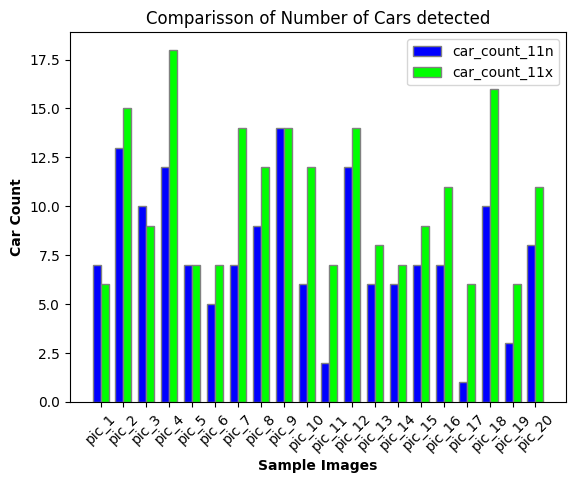

In [12]:
# Sample data
categories = [f'pic_{i+1}' for i in range(len(rand_images_URL))]
car_count_11n = benchmark_results_YOLO_11n['CAR_COUNT'].to_list()
car_count_11x = benchmark_results_YOLO_11x['CAR_COUNT'].to_list()

# Define the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = np.arange(len(categories))
r2 = [x + bar_width for x in r1]

# Create the block plot
plt.bar(r1, car_count_11n, color='blue', width=bar_width, edgecolor='grey', label='car_count_11n')
plt.bar(r2, car_count_11x, color='lime', width=bar_width, edgecolor='grey', label='car_count_11x')

# Add labels
plt.xlabel('Sample Images', fontweight='bold')
plt.ylabel('Car Count', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(categories))], categories, rotation = 45)

# Add legend
plt.legend()

# Show the plot
plt.title('Comparisson of Number of Cars detected')
plt.show()

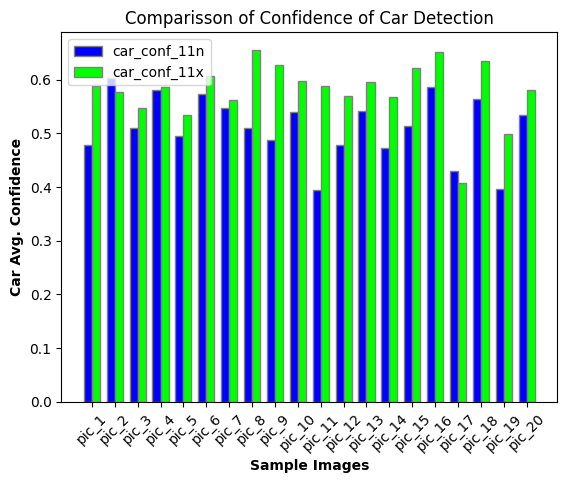

In [13]:
# Sample data
car_confidence_11n = benchmark_results_YOLO_11n['CAR_AVG_CONF'].to_list()
car_confidence_11x = benchmark_results_YOLO_11x['CAR_AVG_CONF'].to_list()

# Define the width of the bars
bar_width = 0.35

# Create the block plot
plt.bar(r1, car_confidence_11n, color='blue', width=bar_width, edgecolor='grey', label='car_conf_11n')
plt.bar(r2, car_confidence_11x, color='lime', width=bar_width, edgecolor='grey', label='car_conf_11x')

# Add labels
plt.xlabel('Sample Images', fontweight='bold')
plt.ylabel('Car Avg. Confidence', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(categories))], categories, rotation = 45)

# Add legend
plt.legend()

# Show the plot
plt.title('Comparisson of Confidence of Car Detection')
plt.show()

[0.5887894630432129, 0.5769078731536865, 0.5474886298179626, 0.5858316421508789, 0.533644437789917, 0.6059908270835876, 0.5630732178688049, 0.6556944847106934, 0.6272731423377991, 0.5982258915901184, 0.5874791145324707, 0.5688393712043762, 0.5953332185745239, 0.567384660243988, 0.6222598552703857, 0.650817334651947, 0.40701010823249817, 0.6357889175415039, 0.49831709265708923, 0.5810503363609314]


C:\Users\f-bon\AppData\Local\Temp\ipykernel_25572\1586660707.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='Confidence', data=df_box_conf, palette='Set2')


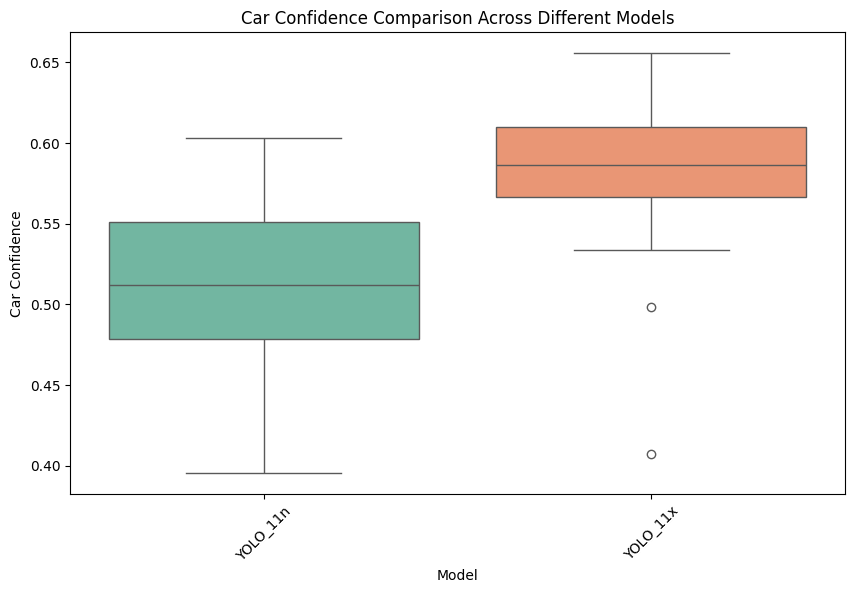

In [14]:
# Create the DataFrame
car_confidence_lists = [car_confidence_11n, car_confidence_11x]

car_confidence_11n, car_confidence_11x = remove_na_from_lists(car_confidence_11n, car_confidence_11x)

car_confidence_11n = [float(conf) for conf in car_confidence_11n]
car_confidence_11x = [float(conf) for conf in car_confidence_11x]

box_plot_data = {
    'Model': ['YOLO_11n'] * len(car_confidence_11n) + ['YOLO_11x'] * len(car_confidence_11x),
    'Confidence': car_confidence_11n + car_confidence_11x
}

df_box_conf = pd.DataFrame(box_plot_data)
# Convert the 'Confidence' column to numeric type
df_box_conf['Confidence'] = pd.to_numeric(df_box_conf['Confidence'], errors='coerce')

print(car_confidence_11x)
df_box_conf.head()
# Create the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='Confidence', data=df_box_conf, palette='Set2')

plt.title('Car Confidence Comparison Across Different Models')
plt.xlabel('Model')
plt.ylabel('Car Confidence')
plt.xticks(rotation=45)

plt.show()